# Genome accessibility

In [19]:
%run ../../shared_setup.ipynb

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [2]:
tbl_regions_1b.display(5, caption='Genome regions classification')

0|region_chrom,1|region_start,2|region_stop,3|region_type,4|region_size
Pf3D7_01_v3,1,27336,SubtelomericRepeat,27336
Pf3D7_01_v3,27337,92900,SubtelomericHypervariable,65564
Pf3D7_01_v3,92901,457931,Core,365031
Pf3D7_01_v3,457932,460311,Centromere,2380
Pf3D7_01_v3,460312,575900,Core,115589


In [3]:
tbl_regions_total_size = (
    tbl_regions_1b
    .aggregate('region_type', sum, 'region_size')
    .rename('value', 'total_size')
)
lkp_regions_total_size = tbl_regions_total_size.lookupone('region_type', 'total_size') 
tbl_regions_total_size.displayall(caption='Total size of region types')

0|region_type,1|total_size
Centromere,31922
Core,20782107
InternalHypervariable,344759
SubtelomericHypervariable,1571888
SubtelomericRepeat,561966


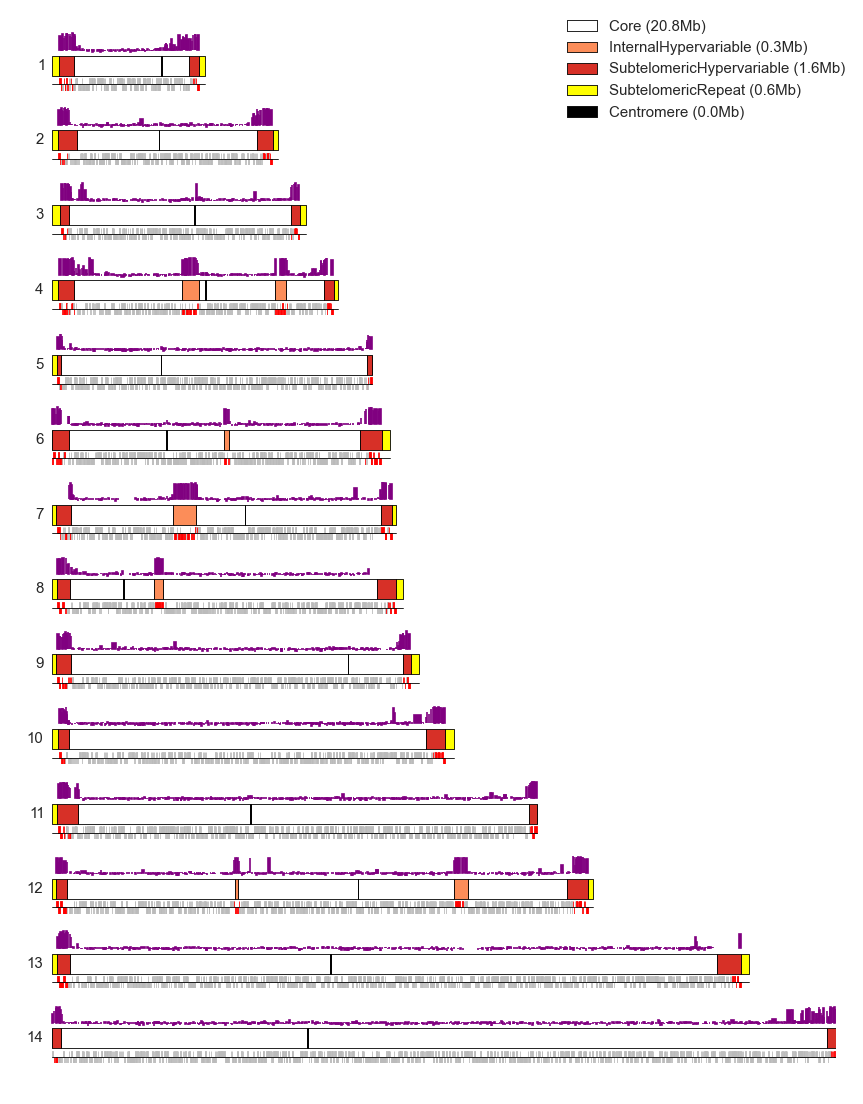

In [4]:
max_chr_size = max(len(fasta[str(chrom, 'ascii')]) for chrom in CHROMOSOMES)

fig = plt.figure(figsize=(7, 9))

gs = mpl.gridspec.GridSpec(4*14, 1, height_ratios=[1, 1, .5, .5]*14)
gs.update(hspace=0)

for i, chrom in enumerate(CHROMOSOMES):
    chrom = str(chrom, 'ascii')
    
    ax = fig.add_subplot(gs[i*4+0])
    plot_hp1(ax, chrom)
    ax.set_xlim(-5000, max_chr_size)
    
    ax = fig.add_subplot(gs[i*4+1])
    plot_accessibility(ax, chrom, linewidth=.5)
    ax.set_xlim(-5000, max_chr_size)
    chrnum = int(chrom[6:8])
    ax.set_ylabel(chrnum, ha='right', va='center', rotation=0)
    
    ax = fig.add_subplot(gs[i*4+2])
    plot_genes(ax, chrom, hypervariable_color='red', normal_color='#bbbbbb', width=.5, divider_linewidth=.5)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(-5000, max_chr_size)
    ax.set_xticks([])
    
fig.tight_layout()

# legend
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
region_types = 'Core', 'InternalHypervariable', 'SubtelomericHypervariable', 'SubtelomericRepeat', 'Centromere'
leg_artists = [plt.Rectangle((0, 0), 1, 1, fc=accessibility_colors[r]) for r in region_types]
leg_labels = ['%s (%.1fMb)' % (r, lkp_regions_total_size[r]*1./1e6) for r in region_types]
ax.legend(leg_artists, leg_labels, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.1)

fn = '../../artwork/supp/genome_regions_map.{dpi}.{fmt}'
for fmt in 'jpeg', 'png':
    for dpi in 120, 300:
        fig.savefig(fn.format(dpi=dpi, fmt=fmt), dpi=dpi, jpeg_quality=100)


In [5]:
tbl_coverage_summary_by_region = etl.fromtsv(os.path.join(PUBLIC_DIR, 'tbl_coverage_summary_by_region.wg.txt')).convertnumbers()
tbl_coverage_summary_by_region.eq('region', 'Core').displayall()

0|run,1|region,2|pc_not_covered
ERR019061,Core,0.06750037424020577
ERR019054,Core,0.12134958211888718
ERR012788,Core,0.10480169311032804
ERR012840,Core,0.05205439467711335
ERR027099,Core,0.32629992714405714
ERR027100,Core,0.1215228080579125


In [6]:
tbl_mq0_summary_by_region = etl.fromtsv(os.path.join(PUBLIC_DIR, 'tbl_mq0_summary_by_region.wg.txt')).convertnumbers()
tbl_mq0_summary_by_region.eq('region', 'Core').displayall()

0|run,1|region,2|pc_mq0
ERR019061,Core,0.8333081915130165
ERR019054,Core,0.9997927544112828
ERR012788,Core,1.0587184446697344
ERR012840,Core,1.0331146885154618
ERR027099,Core,1.1333884480529333
ERR027100,Core,1.1241593549681945


In [7]:
LABELS

{'3d7_hb3': '3D7 x HB3',
 '7g8_gb4': '7G8 x GB4',
 'ERR012788': 'HB3(2)',
 'ERR012840': 'Dd2',
 'ERR019054': 'HB3(1)',
 'ERR019061': '3D7',
 'ERR027099': '7G8',
 'ERR027100': 'GB4',
 'hb3_dd2': 'HB3 x Dd2'}

In [8]:
tbl1 = tbl_coverage_summary_by_region.convert('run', LABELS).rename('pc_not_covered', 'pc_positions').addfield('state', 'no_coverage')
tbl2 = tbl_mq0_summary_by_region.convert('run', LABELS).rename('pc_mq0', 'pc_positions').addfield('state', 'mq0')
df_summary_by_region = tbl1.cat(tbl2).rename('run', 'sample').todataframe()
df_summary_by_region.head()

,sample,region,pc_positions,state
0,3D7,Core,0.067500,no_coverage
1,3D7,InternalHypervariable,0.037127,no_coverage
2,3D7,SubtelomericHypervariable,0.027228,no_coverage
3,3D7,SubtelomericRepeat,0.024201,no_coverage
4,3D7,Centromere,0.056387,no_coverage


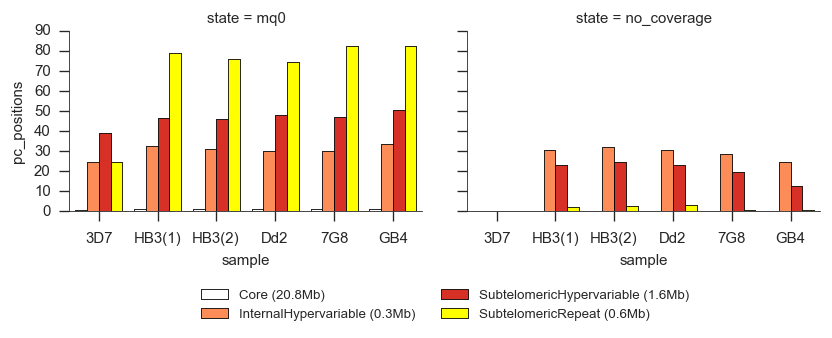

In [9]:
region_colours = [accessibility_colors[r] for r in region_types]
region_types = 'Core', 'InternalHypervariable', 'SubtelomericHypervariable', 'SubtelomericRepeat'
parent_samples = ['3D7', 'HB3(1)', 'HB3(2)', 'Dd2', '7G8', 'GB4']
fg = sns.factorplot(x='sample', y='pc_positions', hue='region', data=df_summary_by_region, kind='bar',
                    hue_order=region_types, col='state',
                    x_order=parent_samples,
                    palette=region_colours, legend=False)

fg.fig.set_size_inches(7, 3)
fg.fig.tight_layout(w_pad=3)
fg.fig.subplots_adjust(bottom=.4)

# legend
ax = fg.fig.add_subplot(111)
#ax = plt.gca()
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
leg_artists = [plt.Rectangle((0, 0), 1, 1, fc=accessibility_colors[r]) for r in region_types]
leg_labels = ['%s (%.1fMb)' % (r, lkp_regions_total_size[r]*1./1e6) for r in region_types]
ax.legend(leg_artists, leg_labels, bbox_to_anchor=(0.5, -0.4), loc='upper center', borderaxespad=0, fontsize=8, ncol=2)

fn = '../../artwork/supp/genome_regions_summary.{dpi}.{fmt}'
for fmt in 'jpeg', 'png':
    for dpi in 120, 300:
        fg.fig.savefig(fn.format(dpi=dpi, fmt=fmt), dpi=dpi, jpeg_quality=100)


In [10]:
bam_fn_template = '/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/bam/{run}.realigned.bam'
stats_fn_template = '/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/cache/{run}.{chrom}.{stats}.npy'

In [14]:
def load_stats(run, chrom, stats, requires_fasta=False):
    stats_fn = stats_fn_template.format(run=run, chrom=chrom, stats=stats)
    if os.path.exists(stats_fn):
        a = np.load(stats_fn, mmap_mode='r').view(np.recarray)
    else:
        f = getattr(pysamstats, 'load_' + stats)
        bam_fn = bam_fn_template.format(run=run)
        bam = pysam.AlignmentFile(bam_fn)
        if requires_fasta:
            fasta = pysam.FastaFile(FASTA_FN)
            a = f(bam, fasta, chrom=chrom)
        else:
            a = f(bam, chrom=chrom)
        np.save(stats_fn, a)
    return a
    

In [15]:
load_stats('ERR019054', 'Pf3D7_01_v3', 'mapq')

rec.array([(b'Pf3D7_01_v3', 2, 4, 4, 2, 2, 7, 7, 10, 10),
       (b'Pf3D7_01_v3', 3, 5, 5, 2, 2, 7, 7, 10, 10),
       (b'Pf3D7_01_v3', 4, 6, 6, 2, 2, 8, 8, 10, 10), ...,
       (b'Pf3D7_01_v3', 640848, 15, 12, 7, 4, 12, 13, 29, 29),
       (b'Pf3D7_01_v3', 640849, 15, 12, 7, 4, 12, 13, 29, 29),
       (b'Pf3D7_01_v3', 640850, 11, 10, 3, 2, 13, 14, 29, 29)], 
      dtype=[('chrom', 'S12'), ('pos', '<i4'), ('reads_all', '<i4'), ('reads_pp', '<i4'), ('reads_mapq0', '<i4'), ('reads_mapq0_pp', '<i4'), ('rms_mapq', '<i4'), ('rms_mapq_pp', '<i4'), ('max_mapq', '<i4'), ('max_mapq_pp', '<i4')])

In [16]:
load_stats('ERR019054', 'Pf3D7_01_v3', 'variation', requires_fasta=True)

rec.array([ (b'Pf3D7_01_v3', 2, b'A', 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0),
       (b'Pf3D7_01_v3', 3, b'A', 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0),
       (b'Pf3D7_01_v3', 4, b'C', 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0),
       ...,
       (b'Pf3D7_01_v3', 640848, b'A', 15, 12, 14, 12, 1, 0, 0, 0, 0, 0, 14, 12, 1, 0, 0, 0, 0, 0, 0, 0),
       (b'Pf3D7_01_v3', 640849, b'G', 15, 12, 15, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 12, 0, 0),
       (b'Pf3D7_01_v3', 640850, b'G', 11, 10, 11, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 10, 0, 0)], 
      dtype=[('chrom', 'S12'), ('pos', '<i4'), ('ref', 'S1'), ('reads_all', '<i4'), ('reads_pp', '<i4'), ('matches', '<i4'), ('matches_pp', '<i4'), ('mismatches', '<i4'), ('mismatches_pp', '<i4'), ('deletions', '<i4'), ('deletions_pp', '<i4'), ('insertions', '<i4'), ('insertions_pp', '<i4'), ('A', '<i4'), ('A_pp', '<i4'), ('C', '<i4'), ('C_pp', '<i4'), ('T', '<i4'), ('T_pp', '<i4')

In [17]:
# tbl_samples = (etl
#     .fromtsv('/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/samples.txt')
#     .addfield('ID', lambda row: '%s/%s/%s' % (row.clone, row.sample, row.run))
# )
# tbl_samples

0|cross,1|clone,2|sample,3|run,4|instrument,5|coverage,6|ID
3d7_hb3,3D7,PG0051-C,ERR019061,Illumina Genome Analyzer II,122X,3D7/PG0051-C/ERR019061
3d7_hb3,C01,PG0065-C,ERR019064,Illumina Genome Analyzer II,163X,C01/PG0065-C/ERR019064
3d7_hb3,C01,PG0062-C,ERR019070,Illumina Genome Analyzer II,108X,C01/PG0062-C/ERR019070
3d7_hb3,C02,PG0055-C,ERR019066,Illumina Genome Analyzer II,102X,C02/PG0055-C/ERR019066
3d7_hb3,C02,PG0053-C,ERR019067,Illumina Genome Analyzer II,73X,C02/PG0053-C/ERR019067


In [15]:
# run2id = tbl_samples.lookupone('run', 'ID')

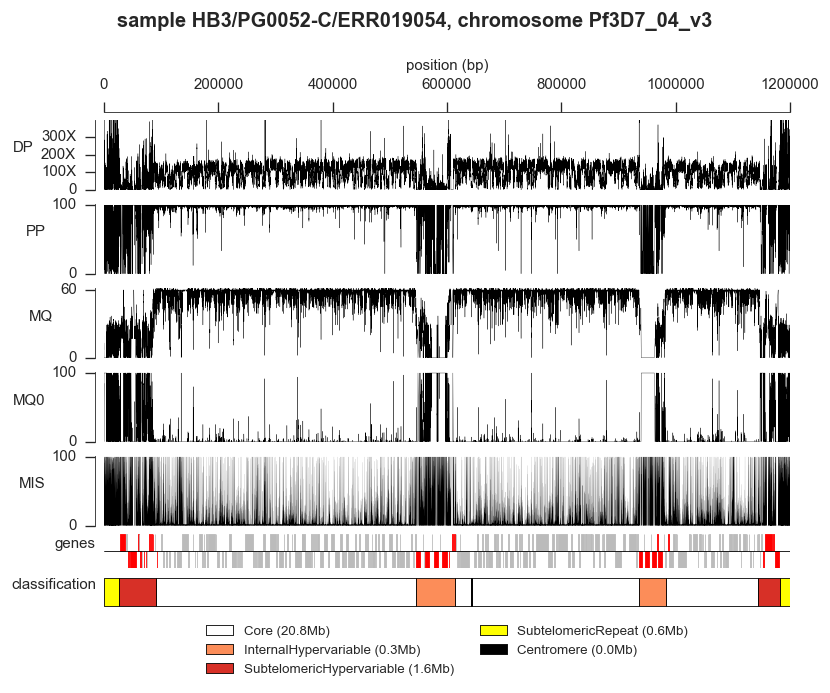

In [23]:
def plot_accessibility_diagnostics(run, chrom, figsize=(7, 7)):
    
    chrlen = len(fasta[chrom])
    
    coverage_ext = load_stats(run, chrom, 'coverage_ext')
    mapq = load_stats(run, chrom, 'mapq')
    variation = load_stats(run, chrom, 'variation', requires_fasta=True)
    
    fig = plt.figure(figsize=figsize)
    
    rows = 6
    i = 0
    
    i += 1
    ax = fig.add_subplot(rows, 1, i)
    sns.despine(ax=ax, bottom=True, top=False, offset=5)
    x = coverage_ext.pos
    y = coverage_ext.reads_all 
#     ax.fill_between(x, 0, y, lw=.1, color='k')
    ax.plot(x, y, lw=.2, color='k')
    ax.set_xlim(0, chrlen)
    ax.set_ylim(0, 400)
    ax.set_ylabel('DP', rotation=0, ha='right')
    ax.set_yticks([0, 100, 200, 300])
    ax.set_yticklabels(['0', '100X', '200X', '300X'])
    ax.set_xlabel('position (bp)')
    ax.xaxis.set_label_position('top')
    
    i += 1
    ax = fig.add_subplot(rows, 1, i)
    sns.despine(ax=ax, bottom=True, offset=5)
    ax.set_xticks([])
    x = coverage_ext.pos
    y = coverage_ext.reads_pp * 100 / coverage_ext.reads_all
#     ax.fill_between(x, 100, y, lw=.1, color='k')
    ax.plot(x, y, lw=.2, color='k')
    ax.set_xlim(0, chrlen)
    ax.set_ylim(0, 102)
    ax.set_yticks([0, 100])
    ax.set_ylabel('PP', rotation=0, ha='right')
    
    i += 1
    ax = fig.add_subplot(rows, 1, i)
    sns.despine(ax=ax, bottom=True, offset=5)
    ax.set_xticks([])
    x = mapq.pos
    y = mapq.rms_mapq
#     ax.fill_between(x, 0, y, lw=.1, color='k')
    ax.plot(x, y, lw=.2, color='k')
    ax.set_xlim(0, chrlen)
    ax.set_ylim(0, 62)
    ax.set_yticks([0, 60])
    ax.set_ylabel('MQ', rotation=0, ha='right')

    i += 1
    ax = fig.add_subplot(rows, 1, i)
    x = mapq.pos
    y = mapq.reads_mapq0 * 100 / mapq.reads_all
#     ax.fill_between(x, 0, y, lw=.1, color='k')
    ax.plot(x, y, lw=.2, color='k')
    ax.set_xlim(0, chrlen)
    ax.set_ylim(0, 102)
    ax.set_yticks([0, 100])
    ax.set_ylabel('MQ0', rotation=0, ha='right')
    sns.despine(ax=ax, bottom=True, offset=5)
    ax.set_xticks([])
    
    i += 1
    ax = fig.add_subplot(rows, 1, i)
    x = variation.pos
    y = variation.mismatches * 100 / variation.reads_all
#     ax.fill_between(x, 0, y, lw=.1, color='k')
    ax.plot(x, y, lw=.05, color='k')
    ax.set_xlim(0, chrlen)
    ax.set_ylim(0, 102)
    ax.set_yticks([0, 100])
    ax.set_ylabel('MIS', rotation=0, ha='right')
    sns.despine(ax=ax, bottom=True, offset=5)
    ax.set_xticks([])
    
    i += 1
    ax = fig.add_subplot(2*rows, 1, 2*i-1)
    sns.despine(ax=ax, bottom=True, offset=5)
    ax.set_xticks([])
    plot_genes(ax, chrom, hypervariable_color='red', normal_color='#bbbbbb', width=.5, divider_linewidth=.5)
    ax.set_xlim(0, chrlen)
    ax.set_ylabel('genes', rotation=0, ha='right')
    ax = fig.add_subplot(2*rows, 1, 2*i)
    sns.despine(ax=ax, bottom=False, offset=5)
    plot_accessibility(ax, chrom, linewidth=.5)
    ax.set_xlim(0, chrlen)
    ax.set_ylabel('classification', rotation=0, ha='right')

    fig.suptitle('sample %s, chromosome %s' % (run2id[run], chrom), fontsize=12, fontweight='bold', y=.98, va='top')
    
    # legend
    region_types = 'Core', 'InternalHypervariable', 'SubtelomericHypervariable', 'SubtelomericRepeat', 'Centromere'
    leg_artists = [plt.Rectangle((0, 0), 1, 1, fc=accessibility_colors[r]) for r in region_types]
    leg_labels = ['%s (%.1fMb)' % (r, lkp_regions_total_size[r]*1./1e6) for r in region_types]
    ax.legend(leg_artists, leg_labels, bbox_to_anchor=(0.5, -0.3), loc='upper center', borderaxespad=0, fontsize=8, ncol=2)

    fig.tight_layout()
    fig.subplots_adjust(hspace=.2, top=.83, bottom=.15)
    
    fn = '../../artwork/supp/genome_regions_example.{dpi}.{fmt}'
    for fmt in 'jpeg', 'png':
        for dpi in 120, 300:
            fig.savefig(fn.format(dpi=dpi, fmt=fmt), dpi=dpi, jpeg_quality=100)
    

plot_accessibility_diagnostics('ERR019054', 'Pf3D7_04_v3', figsize=(7, 6))

## Sandbox

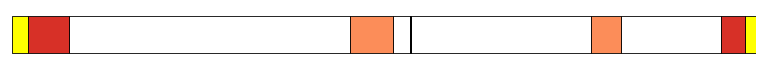

In [19]:
fig, ax = plt.subplots(figsize=(8, .5))
plot_accessibility(ax, 'Pf3D7_04_v3')

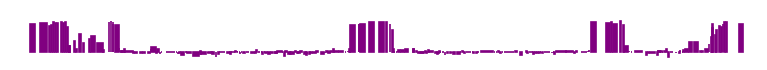

In [20]:
fig, ax = plt.subplots(figsize=(8, .5))
plot_hp1(ax, 'Pf3D7_04_v3')

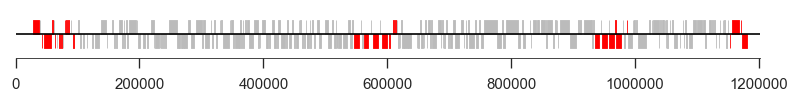

In [21]:
fig, ax = plt.subplots(figsize=(8, .5))
chrom = 'Pf3D7_04_v3'
plot_genes(ax, chrom, hypervariable_color='r', normal_color='#bbbbbb')